In [49]:
import findspark
findspark.init()

In [50]:
import pyspark
import pandas as pd 
import numpy as np
import os 
import datetime
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.window import Window
from math import radians, cos, sin, asin, sqrt
from pyspark.sql import functions as F
from pyspark.sql.functions import col, row_number

from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

pd.set_option('display.max_columns', None)

In [51]:
spark = SparkSession.builder.master("local[*]").config("spark.executor.memory", "22g").config("spark.driver.memory", "22g").config("spark.driver.maxResultSize","0").getOrCreate()

In [52]:
gdrive_path = 'C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data'

In [53]:
wind_grid = spark.read.option("header",True).csv(os.path.join(gdrive_path, 'lookup tables/ERA5_grid.csv'))

In [54]:
wind_grid.printSchema()

root
 |-- grid_index: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)



In [55]:
# convert lat/lon/idx to float/float/int

wind_grid = wind_grid.withColumn("lat",wind_grid.lat.cast('double')).withColumn("lon",wind_grid.lon.cast('double')).withColumn("grid_index",wind_grid.grid_index.cast('integer'))

In [56]:
wind_grid.printSchema()

root
 |-- grid_index: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)



In [57]:
wind_grid.limit(5).show()

+----------+---------+-----------+
|grid_index|      lat|        lon|
+----------+---------+-----------+
|         1|42.279999|-124.410004|
|         2|42.279999|-124.160004|
|         3|42.279999|-123.910004|
|         4|42.279999|-123.660004|
|         5|42.279999|-123.410004|
+----------+---------+-----------+



In [58]:
school_locs = spark.read.option("header",True).csv(os.path.join(gdrive_path, 'schools/filtered_joined_schools_data.csv'))

In [59]:
school_locs = school_locs.select("CDSCode","County","Zip_first_five","OpenDate","ClosedDate","Merged_Lat","Merged_Long")

In [60]:
school_locs = school_locs.withColumnRenamed("County","school_county")\
.withColumnRenamed("Zip_first_five","school_zip")\
.withColumnRenamed("OpenDate","school_open_date")\
.withColumnRenamed("ClosedDate","school_closed_date")\
.withColumnRenamed("Merged_Lat","school_lat")\
.withColumnRenamed("Merged_Long","school_lon")

school_locs.count()

13297

In [61]:
school_locs.limit(5).show()

+-------------+-------------+----------+----------------+------------------+----------+-----------+
|      CDSCode|school_county|school_zip|school_open_date|school_closed_date|school_lat| school_lon|
+-------------+-------------+----------+----------------+------------------+----------+-----------+
|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212| -122.09713|
|1100170109835|      Alameda|     94560|       8/29/2005|         7/31/2015| 37.521436| -121.99391|
|1100170112607|      Alameda|     94612|       8/28/2006|           No Data| 37.804722|-122.268394|
|1100170118489|      Alameda|     94703|       8/21/2008|         6/30/2015| 37.868991| -122.27844|
|1100170123968|      Alameda|     94606|       8/22/2011|           No Data| 37.784653|-122.238651|
+-------------+-------------+----------+----------------+------------------+----------+-----------+



In [62]:
from pyproj import Geod

g = Geod(ellps="WGS84") # Use WGS84 ellipsoid

In [40]:
newyork_lat = 40.+(47./60.); newyork_lon = -73.-(58./60.)
boston_lat = 42.+(15./60.); boston_lon = -71.-(7./60.)
dc_lat = 38.9072; dc_lon = -77.0369
losangeles_lat = 34.0522; losangeles_lon = -118.2437

az12,az21,dist = g.inv(newyork_lon,newyork_lat,boston_lon,boston_lat)
f"{az12:.3f} {az21:.3f} {dist:.3f}"

# compute the azimuths, distances from New York to several
# cities (pass a list)

lons1 = 3*[newyork_lon]; lats1 = 3*[newyork_lat]
lons2 = [boston_lon, dc_lon, losangeles_lon]
lats2 = [boston_lat, dc_lat, losangeles_lat]

az12,az21,dist = g.inv(lons1,lats1,lons2,lats2)
for faz, baz, d in list(zip(az12,az21,dist)):
    print(f"{faz:7.3f} {baz:8.3f} {d:12.3f}")

 54.662 -123.449   288299.735
-127.414   50.619   335283.902
-86.343   65.836  3947232.483


In [63]:
def geod_dist(lat1, lon1, lat2, lon2):
    
    '''Site 2 (lat2/lon2) must be source location (in this case, pollution sites).
       Site 1 (lat1/lon1) must be destination location (schools). AZ12 will look at
       the angle from this point to the schools.'''
    
    az12,az21,dist = g.inv(lon2, lat2, lon1, lat1)
    
    return dist

In [64]:
udf_geod_dist = F.udf(geod_dist)

In [65]:
wind_obs_point_sources = wind_grid.crossJoin(school_locs)

In [66]:
wind_obs_point_sources.count()

22338960

In [67]:
wind_obs_point_sources.limit(5).show()

+----------+---------+-----------+-------------+-------------+----------+----------------+------------------+----------+----------+
|grid_index|      lat|        lon|      CDSCode|school_county|school_zip|school_open_date|school_closed_date|school_lat|school_lon|
+----------+---------+-----------+-------------+-------------+----------+----------------+------------------+----------+----------+
|         1|42.279999|-124.410004|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212|-122.09713|
|         2|42.279999|-124.160004|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212|-122.09713|
|         3|42.279999|-123.910004|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212|-122.09713|
|         4|42.279999|-123.660004|1100170000000|      Alameda|     94544|         No Data|           No Data| 37.658212|-122.09713|
|         5|42.279999|-123.410004|1100170000000|      Alameda|     94544|   

In [68]:
wind_obs_point_sources.printSchema()

root
 |-- grid_index: integer (nullable = true)
 |-- lat: double (nullable = true)
 |-- lon: double (nullable = true)
 |-- CDSCode: string (nullable = true)
 |-- school_county: string (nullable = true)
 |-- school_zip: string (nullable = true)
 |-- school_open_date: string (nullable = true)
 |-- school_closed_date: string (nullable = true)
 |-- school_lat: string (nullable = true)
 |-- school_lon: string (nullable = true)



In [69]:
wind_obs_point_sources = wind_obs_point_sources.withColumnRenamed("lat","wind_lat")
wind_obs_point_sources = wind_obs_point_sources.withColumnRenamed("lon","wind_lon")
wind_obs_point_sources = wind_obs_point_sources.withColumn("school_lat",wind_obs_point_sources.school_lat.cast('double'))
wind_obs_point_sources = wind_obs_point_sources.withColumn("school_lon",wind_obs_point_sources.school_lon.cast('double'))

wind_obs_point_sources.printSchema()

wind_obs_point_sources.cache()

root
 |-- grid_index: integer (nullable = true)
 |-- wind_lat: double (nullable = true)
 |-- wind_lon: double (nullable = true)
 |-- CDSCode: string (nullable = true)
 |-- school_county: string (nullable = true)
 |-- school_zip: string (nullable = true)
 |-- school_open_date: string (nullable = true)
 |-- school_closed_date: string (nullable = true)
 |-- school_lat: double (nullable = true)
 |-- school_lon: double (nullable = true)



DataFrame[grid_index: int, wind_lat: double, wind_lon: double, CDSCode: string, school_county: string, school_zip: string, school_open_date: string, school_closed_date: string, school_lat: double, school_lon: double]

In [70]:
wind_obs_point_sources = wind_obs_point_sources.withColumn("geod_dist_m",\
                        udf_geod_dist(wind_obs_point_sources.wind_lat,wind_obs_point_sources.wind_lon,wind_obs_point_sources.school_lat,wind_obs_point_sources.school_lon).cast(DoubleType()))

In [71]:
wind_obs_point_sources.cache()

DataFrame[grid_index: int, wind_lat: double, wind_lon: double, CDSCode: string, school_county: string, school_zip: string, school_open_date: string, school_closed_date: string, school_lat: double, school_lon: double, geod_dist_m: double]

In [72]:
wind_year_window = Window.partitionBy([col("CDSCode")]).orderBy(col("geod_dist_m").asc())

each_wind_year_min = wind_obs_point_sources.withColumn("row",row_number().over(wind_year_window)).filter(col("row") == 1).drop("row")

In [73]:
%%time

each_wind_year_min_pd = each_wind_year_min.toPandas()

CPU times: total: 31.2 ms
Wall time: 2min 17s


In [74]:
display(each_wind_year_min_pd)

,grid_index,wind_lat,wind_lon,CDSCode,school_county,school_zip,school_open_date,school_closed_date,school_lat,school_lon,geod_dist_m
0,789,36.779999,-119.910004,10101080119628,Fresno,93706,9/8/2009,No Data,36.730273,-119.807915,10656.244662
1,866,36.529999,-119.410004,10621096005839,Fresno,93631,07/01/1880,No Data,36.554793,-119.504582,8904.455363
2,827,36.779999,-119.660004,10621176109920,Fresno,93720,9/3/1991,No Data,36.875241,-119.759962,13828.739232
3,827,36.779999,-119.660004,10621176116313,Fresno,93611,8/30/1999,No Data,36.817300,-119.674236,4329.919880
4,753,36.279999,-120.160004,10621251030477,Fresno,93234,10/2/1991,No Data,36.208894,-120.098567,9630.587612
...,...,...,...,...,...,...,...,...,...,...,...
13292,481,37.779999,-121.910004,7618040116541,Contra Costa,94582,8/25/2008,No Data,37.769265,-121.911224,1196.228964
13293,161,41.779999,-123.910004,8618206005425,Del Norte,95543,7/1/1980,No Data,41.846334,-123.962660,8569.016660
13294,629,38.779999,-120.910004,9618530930214,El Dorado,95623,8/13/2002,No Data,38.681781,-120.838250,12562.186162
13295,780,39.029999,-119.910004,9619030930107,El Dorado,96150,9/2/1992,6/30/2020,38.910453,-120.017583,16218.803772


In [76]:
len(each_wind_year_min_pd.CDSCode.unique())

13297

<AxesSubplot:>

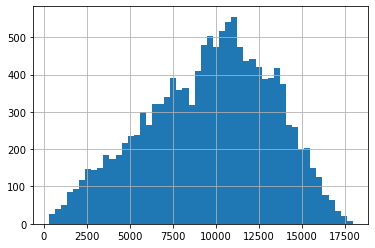

In [77]:
each_wind_year_min_pd.geod_dist_m.hist(bins=50)

In [78]:
each_wind_year_min_pd.to_csv('C:\\Users\\matts\\Google Drive\\berkeley\\.shortcut-targets-by-id\\11wLy1WKwOTcthBs1rpfEzkqax2BZG-6E\\W210_Capstone\\Data\\lookup tables\\wind_grid_to_school_lookup.csv')